<a href="https://colab.research.google.com/github/nguyenvantai102/CS114.L21.KHCL/blob/main/Hand_written_digits_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>CS114.L21.KHCL - MACHINE LEARNING </b></h1>
<h1 align="center"><b>BÀI TẬP COLAB 01. sklearn hand-written digits recognition (16/04/2021)</b></h1>

SOURCE CODE


Nguồn: https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py


In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
from imutils.contours import sort_contours
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

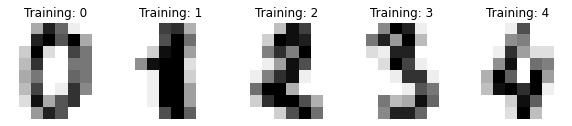

In [2]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)


In [3]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

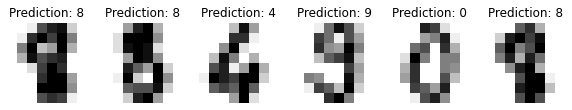

In [4]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')

In [5]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, predicted)}\n")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted a

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


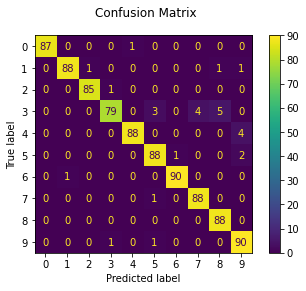

In [6]:
disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

# Lấy ảnh từ camera

In [7]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


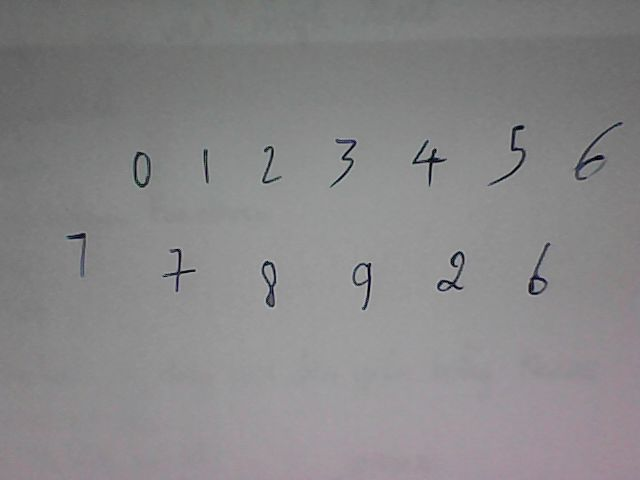

In [38]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Nhóm e chọn chụp trên một bức ảnh để có thể dễ theo dõi dự đoán của những chữ số trên cùng một điều kiện như độ mờ, phản sáng ...

# Chỉnh sửa ảnh đầu vào

- Tạo các bouding box trên ảnh

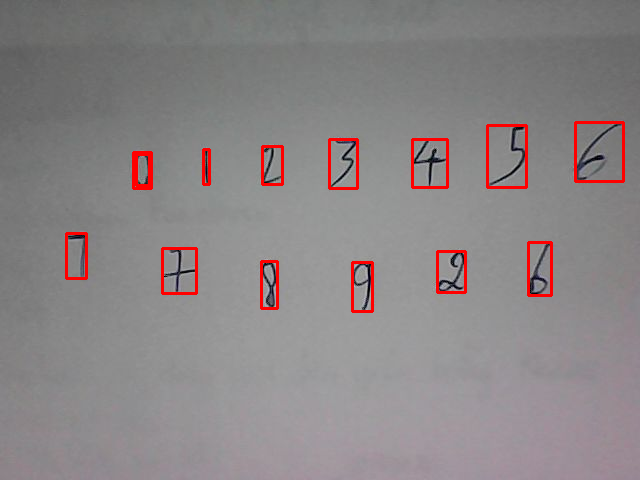

In [51]:
img = cv2.imread('photo.jpg')
im = img.copy()

gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
thresh = cv2.adaptiveThreshold(blur,255,1,1,11,2)

contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

a = []
for cnt in contours:
    if cv2.contourArea(cnt)>50:
        [x,y,w,h] = cv2.boundingRect(cnt)

        if  h>28:
            a.append([x,y,x+w,y+h])
            cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),2)
            roi = thresh[y:y+h,x:x+w]
            roismall = cv2.resize(roi,(10,10))            
            key = cv2.waitKey(0)
cv2_imshow(im)


- Loại bỏ những box có kích thước bằng ảnh 

In [52]:

delete_box = []
for i,bbox in enumerate(a):
    if (bbox[3]-bbox[1] >= 0.9*img.shape[0]) or (bbox[2]-bbox[0] >= 0.9*img.shape[1]):
        a.remove([bbox[0], bbox[1], bbox[2], bbox[3]])
print(a)

[[352, 262, 372, 311], [261, 261, 277, 308], [437, 251, 465, 292], [162, 248, 196, 293], [528, 242, 551, 295], [66, 233, 86, 278], [136, 154, 149, 185], [133, 152, 151, 188], [203, 149, 209, 184], [262, 146, 282, 184], [412, 139, 447, 187], [329, 139, 357, 188], [487, 125, 526, 187], [575, 122, 623, 181]]


In [53]:

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
  # nếu không có ô nào, hãy trả về một danh sách trống
  if len(boxes) == 0:
    return []
  # nếu các hộp giới hạn là số nguyên, hãy chuyển đổi chúng thành số float --
    # điều này rất quan trọng vì chúng ta sẽ thực hiện một loạt các bộ phận
    # if box.dtype.kind == "i":
    # box = box.astype ("float")
    # khởi tạo danh sách các chỉ mục đã chọn	
  pick = []
   # lấy tọa độ của bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
    # tính diện tích của bounding boxes và sắp xếp các bounding
    # hộp theo tọa độ y dưới cùng bên phải của bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
    # tiếp tục lặp trong khi một số chỉ mục vẫn còn trong các chỉ mục
    # danh sách
  while len(idxs) > 0:
    # lấy chỉ mục cuối cùng trong danh sách chỉ mục và thêm
    # giá trị chỉ mục cho danh sách các chỉ mục đã chọn
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
   # tìm tọa độ (x, y) lớn nhất để bắt đầu
    # hộp giới hạn và tọa độ (x, y) nhỏ nhất
    # cho phần cuối của bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
   # tính chiều rộng và chiều cao của bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    # tính tỷ lệ chồng chéo
    overlap = (w * h) / area[idxs[:last]]
    # xóa tất cả các chỉ mục khỏi danh sách chỉ mục có
    idxs = np.delete(idxs, np.concatenate(([last],
    np.where(overlap > overlapThresh)[0])))
    # chỉ trả lại các bounding box đã được chọn bằng cách sử dụng kiểu dữ liệu số nguyên
    
  return boxes[pick].astype("int")


In [54]:
b = np.array(a) #b là mảng các bbox
bbox = non_max_suppression_fast(b,0.4) # Loại bỏ bounding box overlap ( những bbox trùng nhau trên 40% sẽ bị loại bỏ)
bbox = bbox[np.argsort(bbox[:, 0])] # Sắp xếp các bbox từ trái sang phải

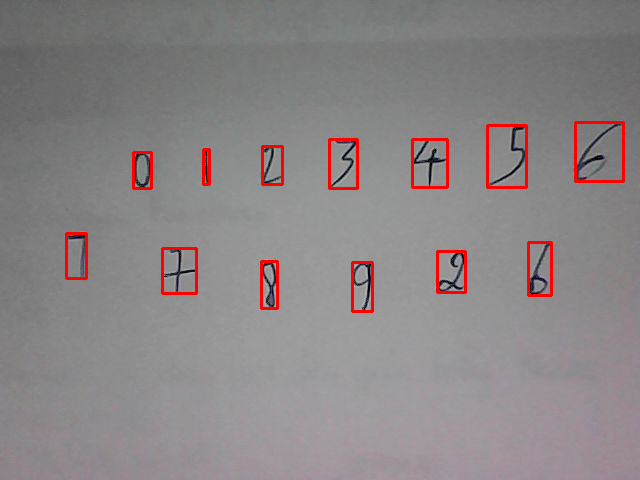

In [55]:
imshow_bbox = img.copy()
for box in bbox:
    cv2.rectangle(imshow_bbox,(box[0],box[1]),(box[2],box[3]),(0,0,255),2)
cv2_imshow(imshow_bbox)

- Cắt các box và reshape hình ảnh về đúng shape của data

In [56]:
digit = []
#gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
thresh_smooth = cv2.GaussianBlur(thresh,(5,5),0)
for box in bbox:
    d = thresh_smooth[box[1]:box[3],box[0]:box[2]] # cắt bbox 
    d = cv2.resize(d,(4,8)) #resize lại hình chữ nhật có kích thước 4x8 (do data có chữ số hơi hẹp nên làm thế này ảnh của mình sẽ giống data hơn)
    d = cv2.copyMakeBorder( d, 0, 0, 2, 2, cv2.BORDER_CONSTANT, 0 ); #Thêm khoảng trống vào 2 cạnh bên để có ảnh 8x8
    cv2_imshow(d) 
    digit.append(d)

digit = np.array(digit)
digit = digit.reshape(len(bbox),64)
print(digit.shape)

(13, 64)


- Chuyển về dạng ma trận đúng kiểu data ban đầu

In [57]:
digit_normalize = (digit/(255/16)).astype(np.int16)
print(digit_normalize)

[[ 0  0 11 12 14 15  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0 14  0  0
   0  0  0  3  0 13  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0 11  0  0
   0  0  0  0  0 10  0  0  0  0  0  1  0 13  0  0]
 [ 0  0  3 14 12  1  0  0  0  0 12  1  1 12  0  0  0  0 13  0  0 14  0  0
   0  0 14  0  0 14  0  0  0  0 13  0  0 11  0  0  0  0 13  0  0 13  0  0
   0  0 11  4  4  9  0  0  0  0  0 13 13  1  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  1  0  0  0  0  7 11 11  4  0  0  0  0  1  1  0  0  0  0
   0  0  0  2  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0 11 15 13  5  0  0  0  0 11 15 12  5  0  0  0  0  9 15 13  6  0  0
   0  0  6 13 13  6  0  0  0  0  2  9 13  6  0  0  0  0  2  9 13  6  0  0
   0  0  2  9 14 11  0  0  0  0  0  4 11 11  0  0]
 [ 0  0  6 14 13  1  0  0  0  0 13  0  2 11  0  0  0  0  8  4  0 12  0  0
   0  0  0 13  2 14  0  0  0  0  0  0 14  1  0  0  0  0  0  1 15  3  0  0
   0  0  0 12  4  7  0  0  0  0  0  5 14  6  0  0]
 [ 0 

- Xuất các ảnh sau khi qua chỉnh sửa ảnh

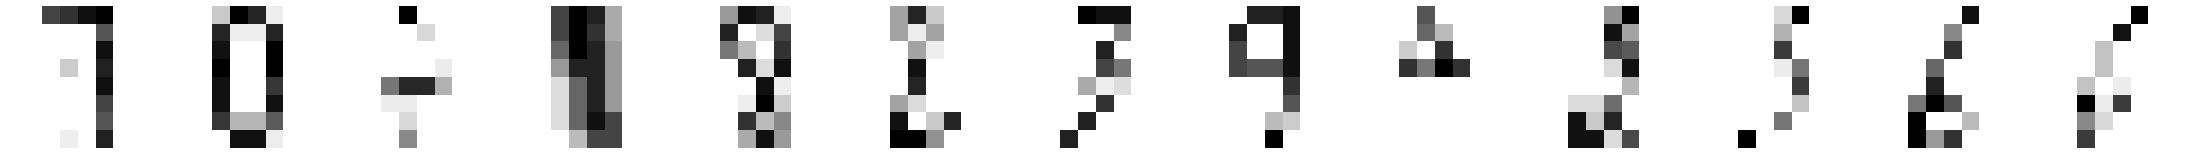

In [58]:
digits = datasets.load_digits()


if (len(digit_normalize) <2):
    digti_img = digit_normalize.reshape(8,8)
    plt.imshow(digti_img, cmap=plt.cm.gray_r, interpolation='nearest')
else:
    _, axes = plt.subplots(nrows=1, ncols=len(digit_normalize), figsize=(len(digit_normalize) * 3, 3))
    for ax, image in zip(axes, digit_normalize):
        ax.set_axis_off()
        digti_img = image.reshape(8,8)
        ax.imshow(digti_img, cmap=plt.cm.gray_r, interpolation='nearest')

In [59]:
pred = clf.predict(digit_normalize)

- Dự đoán test các dạng chữ số có thể viết


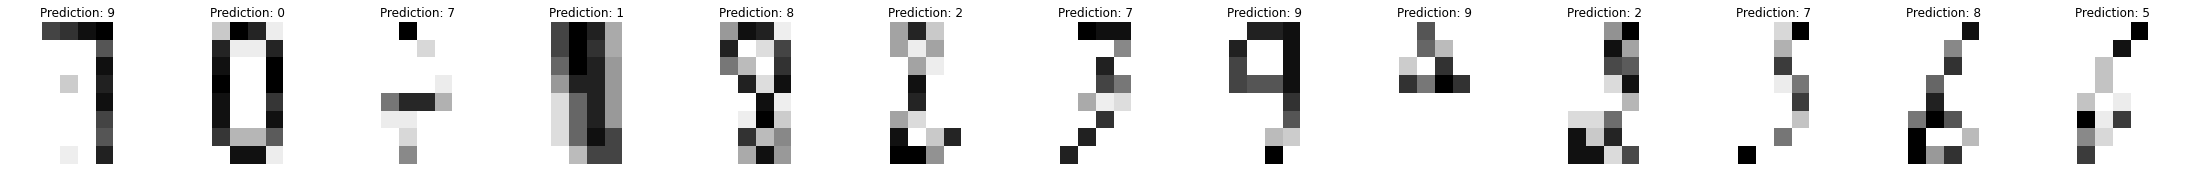

In [60]:
if (len(digit_normalize) <2):
    digti_img = digit_normalize.reshape(8,8)
    plt.title(f'Prediction: {pred[0]}')
    plt.imshow(digti_img, cmap=plt.cm.gray_r, interpolation='nearest')
else:
    _, axes = plt.subplots(nrows=1, ncols=len(digit_normalize), figsize=(len(digit_normalize) * 3, 3))
    for ax, image, prediction in zip(axes, digit_normalize, pred):
        ax.set_axis_off()
        image = image.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title(f'Prediction: {prediction}')

# Xuất ra dự đoán trên ảnh

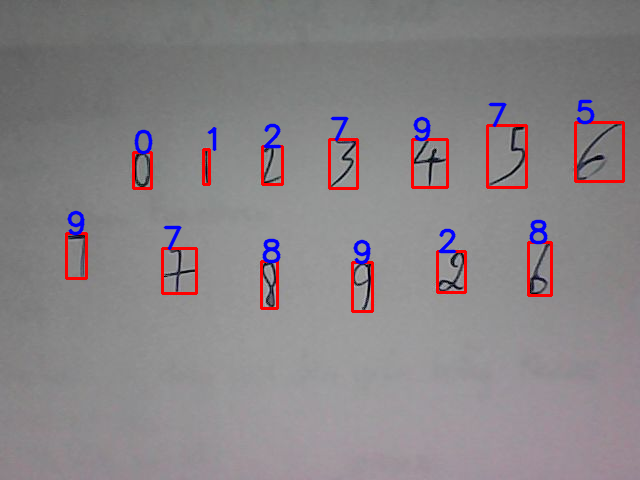

In [61]:
imshow_result = imshow_bbox.copy()
for i,pre in enumerate(pred):
    kq = pre
    vt_bbox = bbox[i]
    vt_text = (vt_bbox[0],vt_bbox[1])
    image = cv2.putText(imshow_bbox, str(kq),vt_text , cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 0, 0), 2, cv2.LINE_AA)
cv2_imshow(image)

# Các câu hỏi đặt ra

###1. Kết quả chạy thực tế với webcam của laptop và giấy viết tay của nhóm có tốt không?
> Theo nhận định của nhóm, kết quả chạy thực tế sử dụng webcam của laptop và giấy viết tay của nhóm là ***chưa tốt.***

###2. Dựa vào cơ sở nào để kết luận là tốt hay không?
- Dựa vào những dự đoán sau khi thử nghiệm các ảnh đầu vào

### 3. Nguyên nhân dự đoán chưa tốt
  - Do sự chuyển đổi ảnh về dạng giống như data ban đầu của bộ dữ liệu chưa thực sự tốt.
  - Các yếu tố khách quan như loại chữ viết, độ tương phản, mờ ...

### 4. Dùng model để nhận diện biển số nhà
  - Model chưa thực sự hiệu quả để có thể nhận diện biển số nhà.
  - Nếu có thể xử lý được ảnh đầu vào tốt hơn để có thể đưa ra những dự đoán chính xác thì có thể được áp dụng vào các bài toán lớn hơn